# Dependencies

In [55]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
from PIL import Image
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

# Custom Dataset

In [56]:
class SimpleVeinDataset(Dataset):
    def __init__(self, csv_file, image_dir, mask_dir):
        """
        Args:
            csv_file (str): Path to CSV with BatID and ImageID columns
            image_dir (str): Path to image folder
            mask_dir (str): Path to mask folder
        """
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.mask_dir = mask_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image ID
        image_id = self.data.iloc[idx]['ImageID']
        
        # Load image and mask
        img_path = os.path.join(self.image_dir, f"{image_id}.png")
        mask_path = os.path.join(self.mask_dir, f"{image_id}.jpg")
        
        # Open and convert to grayscale
        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')
        
        # Convert to tensor and normalize
        image = torch.from_numpy(np.array(image)).float() / 255.0
        mask = torch.from_numpy(np.array(mask)).float() / 255.0
        
        # Add channel dimension
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        return image, mask

# Data Loading

In [57]:
# Create dataset
dataset = SimpleVeinDataset(
    csv_file='../Dataset/dataset.csv',
    image_dir='../Dataset/Images',
    mask_dir='../Dataset/Masks'
)

# Create dataloader
dataloader = DataLoader(
    dataset,
    batch_size=1, #change to 2 when i get to buildling training 
    shuffle=False  #also change this to true
)

# Validating Dataset

In [58]:
def group_and_display_all_bat_images(csv_file, image_dir, mask_dir):
    """
    Group and display all images from all bats
    
    Args:
        csv_file (str): Path to CSV with BatId and ImageID columns
        image_dir (str): Path to image folder
        mask_dir (str): Path to mask folder
    """
    # Read the CSV
    df = pd.read_csv(csv_file)
    
    # Group by BatId
    grouped = df.groupby('BatID')
    
    # Create dataset for loading images
    dataset = SimpleVeinDataset(csv_file, image_dir, mask_dir)
    
    # Get all bat IDs
    all_bats = list(grouped.groups.keys())
    
    for bat_id in all_bats:
        # Get all image IDs for this bat
        bat_images = grouped.get_group(bat_id)
        num_images = len(bat_images)
        
        # Create a figure with enough subplots for all images and masks
        fig, axes = plt.subplots(num_images, 2, figsize=(10, 5*num_images))
        plt.suptitle(f'Bat ID: {bat_id}', fontsize=16)
        
        # If there's only one image, wrap axes in list
        if num_images == 1:
            axes = axes.reshape(1, -1)
        
        # Load and display each image for this bat
        for idx, (_, row) in enumerate(bat_images.iterrows()):
            # Find index in dataset
            dataset_idx = df[df['ImageID'] == row['ImageID']].index[0]
            image, mask = dataset[dataset_idx]
            
            # Display image
            axes[idx, 0].imshow(image.squeeze(), cmap='gray')
            axes[idx, 0].set_title(f'Image {row["ImageID"]}')
            axes[idx, 0].axis('off')
            
            # Display mask
            axes[idx, 1].imshow(mask.squeeze(), cmap='gray')
            axes[idx, 1].set_title(f'Mask {row["ImageID"]}')
            axes[idx, 1].axis('off')
        
        plt.tight_layout()
        plt.show()

# Example usage:
"""
group_and_display_all_bat_images(
    csv_file='your_data.csv',
    image_dir='path/to/Images',
    mask_dir='path/to/Masks'
)
"""

def analyze_bat_distribution(csv_file):
    """
    Analyze the distribution of images across bats
    
    Args:
        csv_file (str): Path to CSV with BatId and ImageID columns
    """
    df = pd.read_csv(csv_file)
    grouped = df.groupby('BatID')
    
    # Get distribution statistics
    image_counts = grouped.size()
    
    print("\nBat Image Distribution:")
    print(f"Total number of bats: {len(image_counts)}")
    print(f"Total number of images: {len(df)}")
    print(f"Average images per bat: {image_counts.mean():.2f}")
    print(f"Min images per bat: {image_counts.min()}")
    print(f"Max images per bat: {image_counts.max()}")
    
    # Plot distribution
    plt.figure(figsize=(10, 5))
    plt.hist(image_counts, bins='auto')
    plt.title('Distribution of Images per Bat')
    plt.xlabel('Number of Images')
    plt.ylabel('Number of Bats')
    plt.show()
    
    # Display counts for each bat
    print("\nDetailed image counts per bat:")
    for bat_id, count in image_counts.items():
        print(f"Bat {bat_id}: {count} images")

"""
**Uncomment this to view all the wing images for each bat!**
group_and_display_all_bat_images(
    csv_file='../Dataset/dataset.csv',
    image_dir='../Dataset/Images',
    mask_dir='../Dataset/Masks'
)
"""

"\n**Uncomment this to view all the wing images for each bat!**\ngroup_and_display_all_bat_images(\n    csv_file='../Dataset/dataset.csv',\n    image_dir='../Dataset/Images',\n    mask_dir='../Dataset/Masks'\n)\n"

# Train/Test Split


Dataset Split Information:
Total number of bats: 46
Number of training bats: 36
Number of test bats: 10

Total number of images: 70
Number of training images: 54
Number of test images: 16

Displaying training samples:


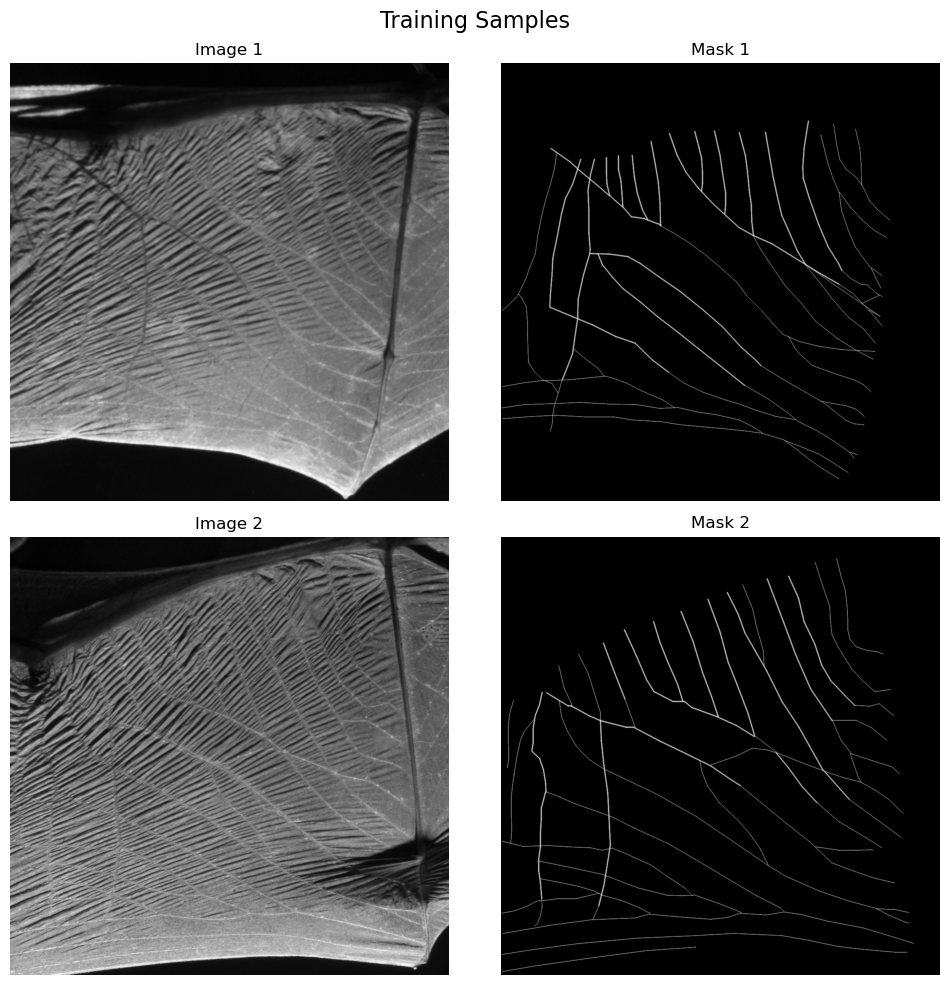


Displaying test samples:


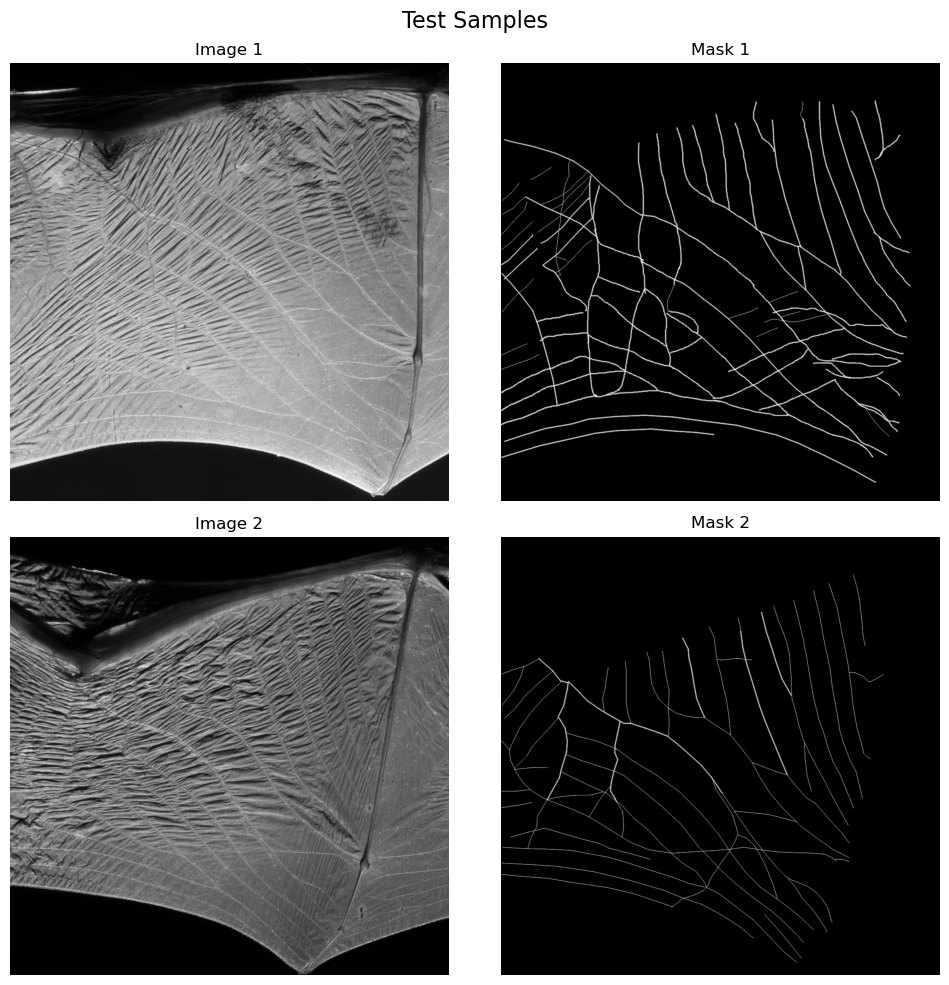


Training Bats: [1, 2, 3, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 41, 43, 44, 46]
Test Bats: [4, 5, 9, 13, 26, 27, 36, 40, 42, 45]


In [59]:
def create_train_test_splits(csv_file, image_dir, mask_dir, test_size=0.2, batch_size=2, random_state=42):
    """
    Create train and test splits while keeping all images from the same bat together
    
    Args:
        csv_file (str): Path to CSV with BatId and ImageID columns
        image_dir (str): Path to image folder
        mask_dir (str): Path to mask folder
        test_size (float): Proportion of data to use for testing (default 0.2)
        batch_size (int): Batch size for dataloaders
        random_state (int): Random seed for reproducibility
        
    Returns:
        train_loader, test_loader, train_bats, test_bats
    """
    # Read the CSV
    df = pd.read_csv(csv_file)
    
    # Get unique bat IDs
    unique_bats = df['BatID'].unique()
    
    # Split bat IDs into train and test
    train_bats, test_bats = train_test_split(
        unique_bats, 
        test_size=test_size,
        random_state=random_state
    )
    
    # Create full dataset
    full_dataset = SimpleVeinDataset(csv_file, image_dir, mask_dir)
    
    # Get indices for train and test splits
    train_indices = df[df['BatID'].isin(train_bats)].index.tolist()
    test_indices = df[df['BatID'].isin(test_bats)].index.tolist()
    
    # Create subset datasets
    train_dataset = Subset(full_dataset, train_indices)
    test_dataset = Subset(full_dataset, test_indices)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        #num_workers=4,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        #num_workers=4,
        pin_memory=True
    )
    
    # Print split information
    print("\nDataset Split Information:")
    print(f"Total number of bats: {len(unique_bats)}")
    print(f"Number of training bats: {len(train_bats)}")
    print(f"Number of test bats: {len(test_bats)}")
    print(f"\nTotal number of images: {len(df)}")
    print(f"Number of training images: {len(train_indices)}")
    print(f"Number of test images: {len(test_indices)}")
    
    return train_loader, test_loader, train_bats, test_bats

def verify_splits(train_loader, test_loader, train_bats, test_bats, num_samples=3):
    """
    Verify the splits by displaying some samples from both train and test sets
    """
    # Function to display batch
    def show_batch(loader, title):
        # Get a batch
        images, masks = next(iter(loader))
        
        # Display up to num_samples from the batch
        n = min(num_samples, len(images))
        fig, axes = plt.subplots(n, 2, figsize=(10, 5*n))
        plt.suptitle(title, fontsize=16)
        
        for i in range(n):
            # Display image
            axes[i, 0].imshow(images[i].squeeze(), cmap='gray')
            axes[i, 0].set_title(f'Image {i+1}')
            axes[i, 0].axis('off')
            
            # Display mask
            axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')
            axes[i, 1].set_title(f'Mask {i+1}')
            axes[i, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Show samples from both splits
    print("\nDisplaying training samples:")
    show_batch(train_loader, "Training Samples")
    
    print("\nDisplaying test samples:")
    show_batch(test_loader, "Test Samples")
    
    # Print bat IDs in each split
    print("\nTraining Bats:", sorted(train_bats))
    print("Test Bats:", sorted(test_bats))



# Create the splits
train_loader, test_loader, train_bats, test_bats = create_train_test_splits(
    csv_file='../Dataset/dataset.csv',
    image_dir='../Dataset/Images',
    mask_dir='../Dataset//Masks',
    test_size=0.2,
    batch_size=2
)

# Verify the splits
verify_splits(train_loader, test_loader, train_bats, test_bats)


# Initialize Model

In [60]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """
    Double Convolution block:
    (Conv2d -> BatchNorm -> ReLU) * 2
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        """
        Standard U-Net architecture
        Args:
            in_channels (int): Number of input channels (1 for grayscale, 3 for RGB)
            out_channels (int): Number of output channels (1 for binary segmentation)
            features (list): Feature dimensions for each level
        """
        super().__init__()
        
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling/Encoder path
        in_feat = in_channels
        for feature in features:
            self.downs.append(DoubleConv(in_feat, feature))
            in_feat = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Upsampling/Decoder path
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        # Optional sigmoid for binary segmentation
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Store skip connections
        skip_connections = []

        # Encoder path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse skip connections list for easier access
        skip_connections = skip_connections[::-1]

        # Decoder path
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # Upsample
            skip = skip_connections[idx//2]

            # Handle cases where input dimensions aren't perfectly divisible by 2
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)

            # Concatenate with skip connection
            concat_skip = torch.cat((skip, x), dim=1)
            
            # Double convolution
            x = self.ups[idx+1](concat_skip)

        # Final 1x1 convolution and sigmoid
        return self.sigmoid(self.final_conv(x))

# Example usage:

# Initialize model
model = UNet(
    in_channels=1,  # 1 for grayscale
    out_channels=1, # 1 for binary segmentation
    features=[64, 128, 256, 512]  # Feature dimensions at each level
)

# Loss, Optimizer and Device

In [61]:
# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

device(type='cuda')

In [62]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, predictions, targets):
        # Flatten predictions and targets
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Calculate Dice coefficient
        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.dice = DiceLoss()
        self.bce = nn.BCELoss()
        
    def forward(self, predictions, targets):
        dice_loss = self.dice(predictions, targets)
        bce_loss = self.bce(predictions, targets)
        
        return self.dice_weight * dice_loss + self.bce_weight * bce_loss

def setup_training(model, learning_rate=1e-4, loss_type='combined'):
    """
    Set up loss function and optimizer for training
    
    Args:
        model: The U-Net model
        learning_rate: Learning rate for the optimizer
        loss_type: One of 'bce', 'dice', or 'combined'
        
    Returns:
        criterion: Loss function
        optimizer: Optimizer
    """
    # Set up loss function
    if loss_type == 'bce':
        criterion = nn.BCELoss()
    elif loss_type == 'dice':
        criterion = DiceLoss()
    elif loss_type == 'combined':
        criterion = CombinedLoss(dice_weight=0.5, bce_weight=0.5)
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")
    
    # Set up optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Optional: Set up learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=5,
        verbose=True
    )
    
    return criterion, optimizer, scheduler

# Example usage:
"""
# Initialize model
model = UNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Set up training components
criterion, optimizer, scheduler = setup_training(
    model,
    learning_rate=1e-4,
    loss_type='combined'  # Use combined BCE and Dice loss
)

# Example training loop (single batch)
def train_step(images, masks):
    # Move data to device
    images = images.to(device)
    masks = masks.to(device)
    
    # Zero gradients
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(images)
    
    # Calculate loss
    loss = criterion(predictions, masks)
    
    # Backward pass
    loss.backward()
    
    # Update weights
    optimizer.step()
    
    return loss.item()
"""

# Setup with combined loss
criterion, optimizer, scheduler = setup_training(
    model,
    learning_rate=1e-4,
    loss_type='combined'
)

c:\Users\Robby\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Training Loop

TypeError: train_model() missing 1 required positional argument: 'val_loader'